# CMS Open Payments analysis

<p><a name="sections"></a></p>


## Sections

- <a href="#import">Import data and Python packages</a><br>
- <a href="#cleaning">Assess Data Quality & Missing Values</a><br>
- <a href="#exploratory">Exploratory Data Analysis</a><br>
- <a href="#prediction">Prediction and Results</a><br>

<p><a name="import"></a></p>

## <i>1. Import data and Python packages</i>

In [194]:
#Import all the necessary packages for data analysis 

import pandas as pd
import numpy as np

import sklearn
from sklearn import model_selection, linear_model
from sklearn import feature_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math


from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [195]:
#Import datasets

general = pd.read_csv('data/OP_DTL_GNRL_PGYR2017_P06282019.csv',low_memory=False)
#general = pd.read_csv('data/OP_DTL_GNRL_Sample.csv',low_memory=False)

research = pd.read_csv('data/OP_DTL_RSRCH_PGYR2017_P06282019.csv',low_memory=False)
ownership = pd.read_csv('data/OP_DTL_OWNRSHP_PGYR2017_P06282019.csv',low_memory=False)
removed = pd.read_csv('data/OP_REMOVED_DELETED_PGYR2017_P06282019.csv',low_memory=False)

In [196]:
#Flag research records

general['Research']=0.0
research['Research']=1.0
ownership['Research']=0.0
removed['Research']=0.0

In [197]:
print(general.shape)
print(research.shape)
print(ownership.shape)
print(removed.shape)

(112398, 76)
(653488, 177)
(2840, 30)
(95583, 5)


In [198]:
#Remove null records

general.dropna(how='all', inplace=True)
research.dropna(how='all', inplace=True)
ownership.dropna(how='all', inplace=True)
removed.dropna(how='all', inplace=True)

In [199]:
general.info()
research.info()
ownership.info()
removed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112398 entries, 0 to 112397
Data columns (total 76 columns):
Change_Type                                                          112398 non-null object
Covered_Recipient_Type                                               112398 non-null object
Teaching_Hospital_CCN                                                415 non-null float64
Teaching_Hospital_ID                                                 415 non-null float64
Teaching_Hospital_Name                                               415 non-null object
Physician_Profile_ID                                                 111983 non-null float64
Physician_First_Name                                                 111981 non-null object
Physician_Middle_Name                                                66305 non-null object
Physician_Last_Name                                                  111980 non-null object
Physician_Name_Suffix                                               

In [200]:
#Remove Ownership and Removed datasets (statistically insignificant)
#Reduce the number of attributes (columns) 

general_data=general[['Record_ID','Teaching_Hospital_Name','Physician_First_Name','Physician_Last_Name','Physician_Primary_Type','Recipient_State','Recipient_Zip_Code','Recipient_Country','Physician_Primary_Type','Physician_Specialty','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name','Total_Amount_of_Payment_USDollars','Covered_Recipient_Type','Research']]
research_data=research[['Record_ID','Teaching_Hospital_Name','Physician_First_Name','Physician_Last_Name','Physician_Primary_Type','Recipient_State','Recipient_Zip_Code','Recipient_Country','Physician_Primary_Type','Physician_Specialty','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name','Total_Amount_of_Payment_USDollars','Covered_Recipient_Type','Research']]

In [201]:
print(general_data.shape)
print(research_data.shape)

(112398, 14)
(653488, 14)


In [202]:
general_data.head()

,Record_ID,Teaching_Hospital_Name,Physician_First_Name,Physician_Last_Name,Physician_Primary_Type,Recipient_State,Recipient_Zip_Code,Recipient_Country,Physician_Primary_Type,Physician_Specialty,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Total_Amount_of_Payment_USDollars,Covered_Recipient_Type,Research
0,422181493,NaN,MARK,GINSBURG,Doctor of Osteopathy,PA,19013,United States,Doctor of Osteopathy,Allopathic & Osteopathic Physicians|Otolaryngo...,Bovie Medical Corporation,22.43,Covered Recipient Physician,0.0
1,422181889,NaN,JACK,ZAMORA,Medical Doctor,CO,80209,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Ophthalmology,Bovie Medical Corporation,12.60,Covered Recipient Physician,0.0
2,423116325,NaN,SANILA,RANA,Medical Doctor,TX,77027-7311,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,Mission Pharmacal Company,11.18,Covered Recipient Physician,0.0
3,423116735,NaN,GARNET,MAHARAJH,Medical Doctor,NC,28110-7767,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Pediatrics,Mission Pharmacal Company,16.64,Covered Recipient Physician,0.0
4,423115739,NaN,MARY,SCANLON,Medical Doctor,IL,60169-5700,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Obstetrics...,Mission Pharmacal Company,11.67,Covered Recipient Physician,0.0


In [203]:
research_data.head()

,Record_ID,Teaching_Hospital_Name,Physician_First_Name,Physician_Last_Name,Physician_Primary_Type,Recipient_State,Recipient_Zip_Code,Recipient_Country,Physician_Primary_Type,Physician_Specialty,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Total_Amount_of_Payment_USDollars,Covered_Recipient_Type,Research
0,493381041,GRADY MEMORIAL HOSPITAL,NaN,NaN,NaN,GA,30303,United States,NaN,NaN,"Pharmacyclics LLC, An AbbVie Company",50.0,Covered Recipient Teaching Hospital,1.0
1,455805444,ST. FRANCIS HOSPITAL,NaN,NaN,NaN,WI,53215,United States,NaN,NaN,"Biogen, Inc.",5.0,Covered Recipient Teaching Hospital,1.0
2,501931627,NaN,BERNARD,STULBERG,Medical Doctor,OH,44139-2839,United States,Medical Doctor,Allopathic & Osteopathic Physicians|Orthopaedi...,Corin USA,800.0,Covered Recipient Physician,1.0
3,501847091,U OF U HOSPITALS & CLINICS,NaN,NaN,NaN,UT,84132,United States,NaN,NaN,Pfizer Inc.,600.0,Covered Recipient Teaching Hospital,1.0
4,446594329,DANBURY HOSPITAL,NaN,NaN,NaN,CT,06810-6099,United States,NaN,NaN,Boston Scientific Corporation,2652.0,Covered Recipient Teaching Hospital,1.0


In [204]:
#Join datasets

total=[general_data,research_data]
cms_data=pd.concat(total)
print(cms_data.shape)

(765886, 14)


<p><a name="cleaning"></a></p>

## <i>2. Assess Data Quality & Missing Values</i>

In [205]:
#Determine the cleaness of the dataset and missing values 

cms_data.isnull().sum()

Record_ID                                                             0
Teaching_Hospital_Name                                           661103
Physician_First_Name                                             625101
Physician_Last_Name                                              625102
Physician_Primary_Type                                           625099
Recipient_State                                                    1225
Recipient_Zip_Code                                                 1225
Recipient_Country                                                   659
Physician_Primary_Type                                           625099
Physician_Specialty                                              625251
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name         0
Total_Amount_of_Payment_USDollars                                     0
Covered_Recipient_Type                                                0
Research                                                        

In [206]:
#Clean null values on key categorical attributes

cms_data['Physician_Primary_Type'] = cms_data['Physician_Primary_Type'].fillna('Not a Physician')
print(cms_data.shape)
cms_data.isnull().sum()

(765886, 14)


Record_ID                                                             0
Teaching_Hospital_Name                                           661103
Physician_First_Name                                             625101
Physician_Last_Name                                              625102
Physician_Primary_Type                                                0
Recipient_State                                                    1225
Recipient_Zip_Code                                                 1225
Recipient_Country                                                   659
Physician_Primary_Type                                                0
Physician_Specialty                                              625251
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name         0
Total_Amount_of_Payment_USDollars                                     0
Covered_Recipient_Type                                                0
Research                                                        

<p><a name="exploratory"></a></p>

## <i>3. Exploratory Data Analysis</i>

#### 3.1. Sampling and Feature Analysis

In [207]:
#Sample size=883,282 (95% Confidence)

cms_data=cms_data.sample(883282)
print(cms_data.shape)
cms_data.sample(25)

ValueError: Cannot take a larger sample than population when 'replace=False'

#### 3.2. Exploration of Location

In [208]:
print(cms_data.shape)
cms_data['Recipient_Country'].value_counts()

(765886, 14)


United States                           764661
Great Britain (Uk)                         441
Canada                                      97
Belgium                                     16
Germany                                      3
United States Minor Outlying Islands         3
Japan                                        2
Australia                                    1
Poland                                       1
Mexico                                       1
Denmark                                      1
Name: Recipient_Country, dtype: int64

In [209]:
cms_data=cms_data[pd.notnull(cms_data['Recipient_State'])]
print(cms_data.shape)
cms_data.isnull().sum()

(764661, 14)


Record_ID                                                             0
Teaching_Hospital_Name                                           659878
Physician_First_Name                                             623881
Physician_Last_Name                                              623882
Physician_Primary_Type                                                0
Recipient_State                                                       0
Recipient_Zip_Code                                                    0
Recipient_Country                                                     0
Physician_Primary_Type                                                0
Physician_Specialty                                              624031
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name         0
Total_Amount_of_Payment_USDollars                                     0
Covered_Recipient_Type                                                0
Research                                                        

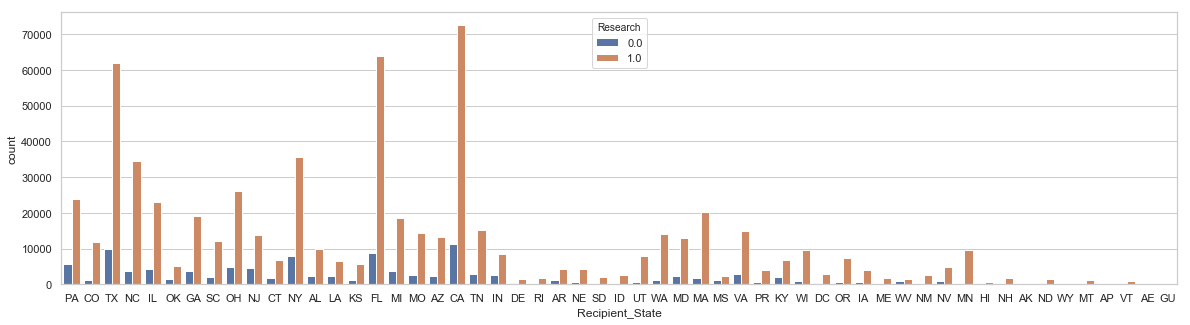

In [210]:
fig = plt.gcf()
fig.set_size_inches(20, 5)
sns.countplot(x='Recipient_State',hue='Research',data=cms_data)

#### 3.3. Exploration of Type of Payments

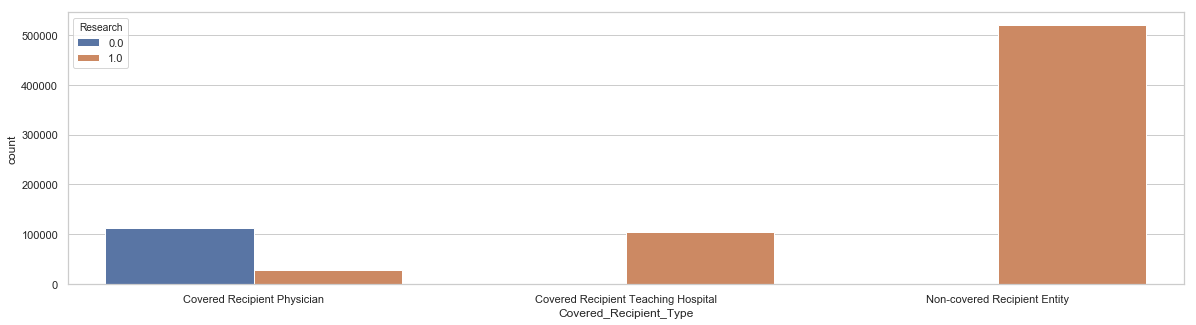

In [211]:
fig = plt.gcf()
fig.set_size_inches(20, 5)
sns.countplot(x='Covered_Recipient_Type',hue='Research',data=cms_data)

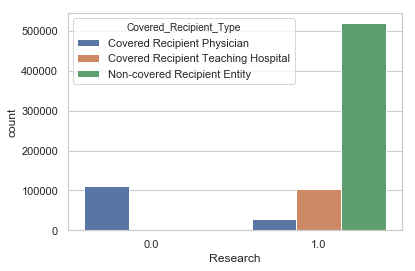

In [212]:
sns.countplot(x='Research',hue='Covered_Recipient_Type',data=cms_data)

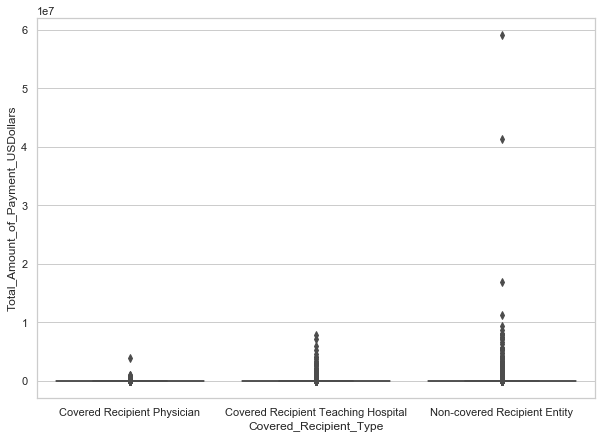

In [213]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Covered_Recipient_Type',y='Total_Amount_of_Payment_USDollars',data=cms_data)

#### 3.4. Feature Engineering

In [214]:
#Create categorical dummy variables

#physicianType_dummy = pd.get_dummies(cms_data['Physician_Primary_Type'])
#state_dummy = pd.get_dummies(cms_data['Recipient_State'])
paymentType_dummy = pd.get_dummies(cms_data['Covered_Recipient_Type'])

<p><a name="prediction"></a></p>

## <i>4. Prediction and Results</i>

#### 4.1. Logistic Regression

In [215]:
y = np.array(cms_data['Research'])
y.shape

(764661,)

In [216]:
X = np.array(cms_data[['Total_Amount_of_Payment_USDollars']])

In [217]:
X.shape

(764661, 1)

In [218]:
np.hstack([X, paymentType_dummy]).shape

(764661, 4)

In [219]:
#Cross validation to split the data 70% training and %30 testing

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [220]:
#Fit model to the training set

model = LogisticRegression()
model.fit(X_train,y_train)
model.score(X_train, y_train)

C:\Users\s_mas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8528440277845242

In [221]:
#Perform prediction

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

C:\Users\s_mas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\s_mas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     33626
         1.0       0.85      1.00      0.92    195773

   micro avg       0.85      0.85      0.85    229399
   macro avg       0.43      0.50      0.46    229399
weighted avg       0.73      0.85      0.79    229399



C:\Users\s_mas\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [222]:
# check classification scores of logistic regression

prediction_proba = model.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, prediction_proba)
print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, prediction))
print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, prediction_proba))
print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.853
LogisticRegression log_loss is 0.333
LogisticRegression auc is 0.901


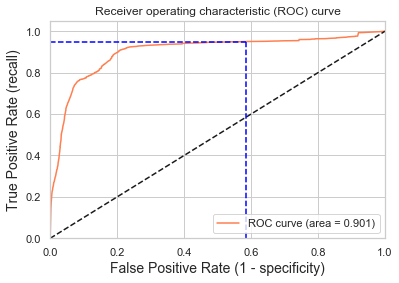

Using a threshold of 0.623 guarantees a sensitivity of 0.950 and a specificity of 0.417, i.e. a false positive rate of 58.34%.


In [223]:
idx = np.min(np.where(tpr > 0.95)) # index threshold 

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [224]:
RMSE=math.sqrt(mean_squared_error(y_true=y_test,y_pred=prediction))

In [225]:
print(RMSE)

0.3828616301287993


#### Visualization of the Models using Receiver Characteristic Curve (ROC) for Logistic Regression

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.901


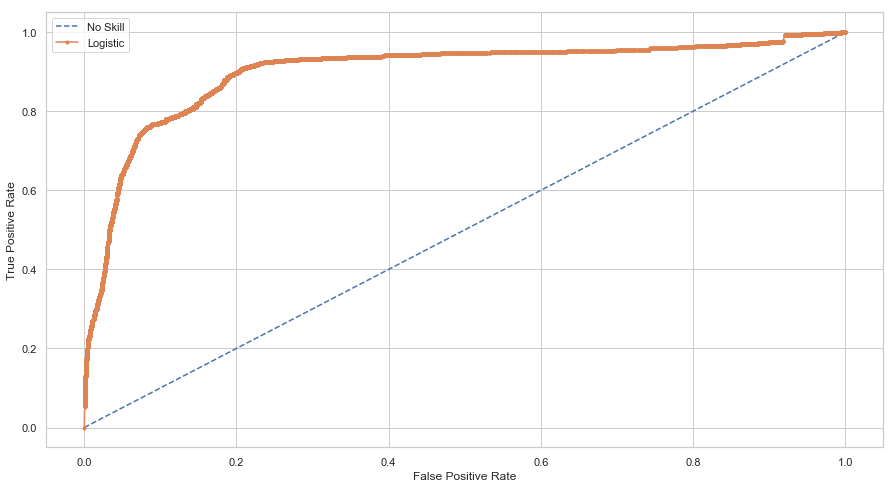

In [226]:
# roc curve and auc - generate a no skill prediction (majority class)

ns_probs = [0 for _ in range(len(y_test))]

# fit a model

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()


fig = plt.gcf()
fig.set_size_inches(15, 8)

# show the plot
plt.show()

#### 4.2. Decision Tree

In [227]:
#Decision tree approach (top down)

regressor = DecisionTreeRegressor(max_depth=20)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [228]:
prediction = regressor.predict(X_test)
prediction

array([1.  , 1.  , 0.98, ..., 0.97, 0.98, 0.97])

In [229]:
print('Accuracy of Random forest on test set: {:.3f}'.format(regressor.score(X_test, y_test)))

Accuracy of Random forest on test set: 0.619


In [230]:
RMSE=math.sqrt(mean_squared_error(y_true = y_test, y_pred = prediction))
print(RMSE)

0.218395590040479


In [231]:
RMSE=math.sqrt(mean_squared_error(y_true = y_test, y_pred = prediction))
print(RMSE)

0.218395590040479


#### 4.3. Random Forest

In [232]:
#from sklearn.datasets import make_classification

rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [233]:
prediction = rfc.predict(X_test)
print('Accuracy of Random forest on test set: {:.3f}'.format(rfc.score(X_test, y_test)))

Accuracy of Random forest on test set: 0.907


In [234]:
RMSE=math.sqrt(mean_squared_error(y_true = y_test, y_pred = prediction))
print(RMSE)

0.3043143178390822
